In [9]:
import numpy as np
import pandas as pd
from nltk.translate.bleu_score import sentence_bleu
from spacy.lang.en.examples import sentences 
import spacy as sp
import nltk
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
#nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
%matplotlib inline
# import zipfile
from textblob import TextBlob
import string
from datetime import datetime  
from datetime import timedelta  
import re 
import matplotlib.pyplot as plt


In [2]:
stock = pd.read_csv('data/SP500_intraday.csv')
stock['Time_pd'] = pd.to_timedelta(stock['Time']+':00')
stock['Date_time'] = pd.to_datetime(pd.to_datetime(stock['Date'])+ pd.to_timedelta(stock['Time_pd']))
stock.head()

,Date,Time,Open,High,Low,Close,Volume,Tick Count,Up Ticks,Down Ticks,Same Ticks,VWAP,Time_pd,Date_time
0,11/13/16,17:01,2183.00,2183.50,2182.25,2183.25,2536,326,66,63,197,2183.03,17:01:00,2016-11-13 17:01:00
1,11/13/16,17:02,2183.25,2183.25,2182.00,2182.00,891,141,18,23,100,2182.93,17:02:00,2016-11-13 17:02:00
2,11/13/16,17:03,2182.00,2182.75,2182.00,2182.75,326,71,15,12,44,2182.27,17:03:00,2016-11-13 17:03:00
3,11/13/16,17:04,2182.50,2182.75,2182.50,2182.50,50,35,7,8,20,2182.57,17:04:00,2016-11-13 17:04:00
4,11/13/16,17:05,2182.75,2183.00,2182.75,2183.00,232,33,8,6,19,2182.92,17:05:00,2016-11-13 17:05:00


In [3]:
test_df = pd.read_csv('data/preprocessed', usecols = ['created_at', 'stock_up'])
stock['Date_time'].loc[stock['Date_time'] == test_df['created_at'][0]].index[0]


105

In [66]:
neural_pred = pd.read_csv('data/neural_prediction', usecols=['0', 'created_at'])
neural_pred['stock_up'] = [1 if neural_pred['0'][i]>=0.5 else 0 for i in range(len(pred))]
neural_pred.head()


,0,created_at,stock_up
0,0.005049,2019-09-29 23:07:00,0
1,0.446433,2018-10-29 00:12:00,0
2,0.181295,2017-12-04 12:00:00,0
3,0.215928,2019-06-11 11:51:00,0
4,0.733370,2019-08-08 00:15:00,1


In [64]:
rf_pred = pd.read_csv('data/rf_prediction', usecols=['0', 'created_at'])
rf_pred['stock_up'] = [1 if rf_pred['0'][i]>=0.5 else 0 for i in range(len(rf_pred))]
rf_pred.head()


,0,created_at,stock_up
144,1,2019-04-18 12:07:00,1
152,1,2018-08-10 12:32:00,1
235,1,2018-02-28 12:29:00,1
247,1,2019-08-22 14:21:00,1
293,1,2018-12-07 03:08:00,1
316,1,2019-05-19 19:54:00,1
335,1,2018-06-06 13:16:00,1
411,1,2019-08-23 14:59:00,1
579,1,2018-04-17 12:24:00,1
604,1,2018-04-27 13:11:00,1


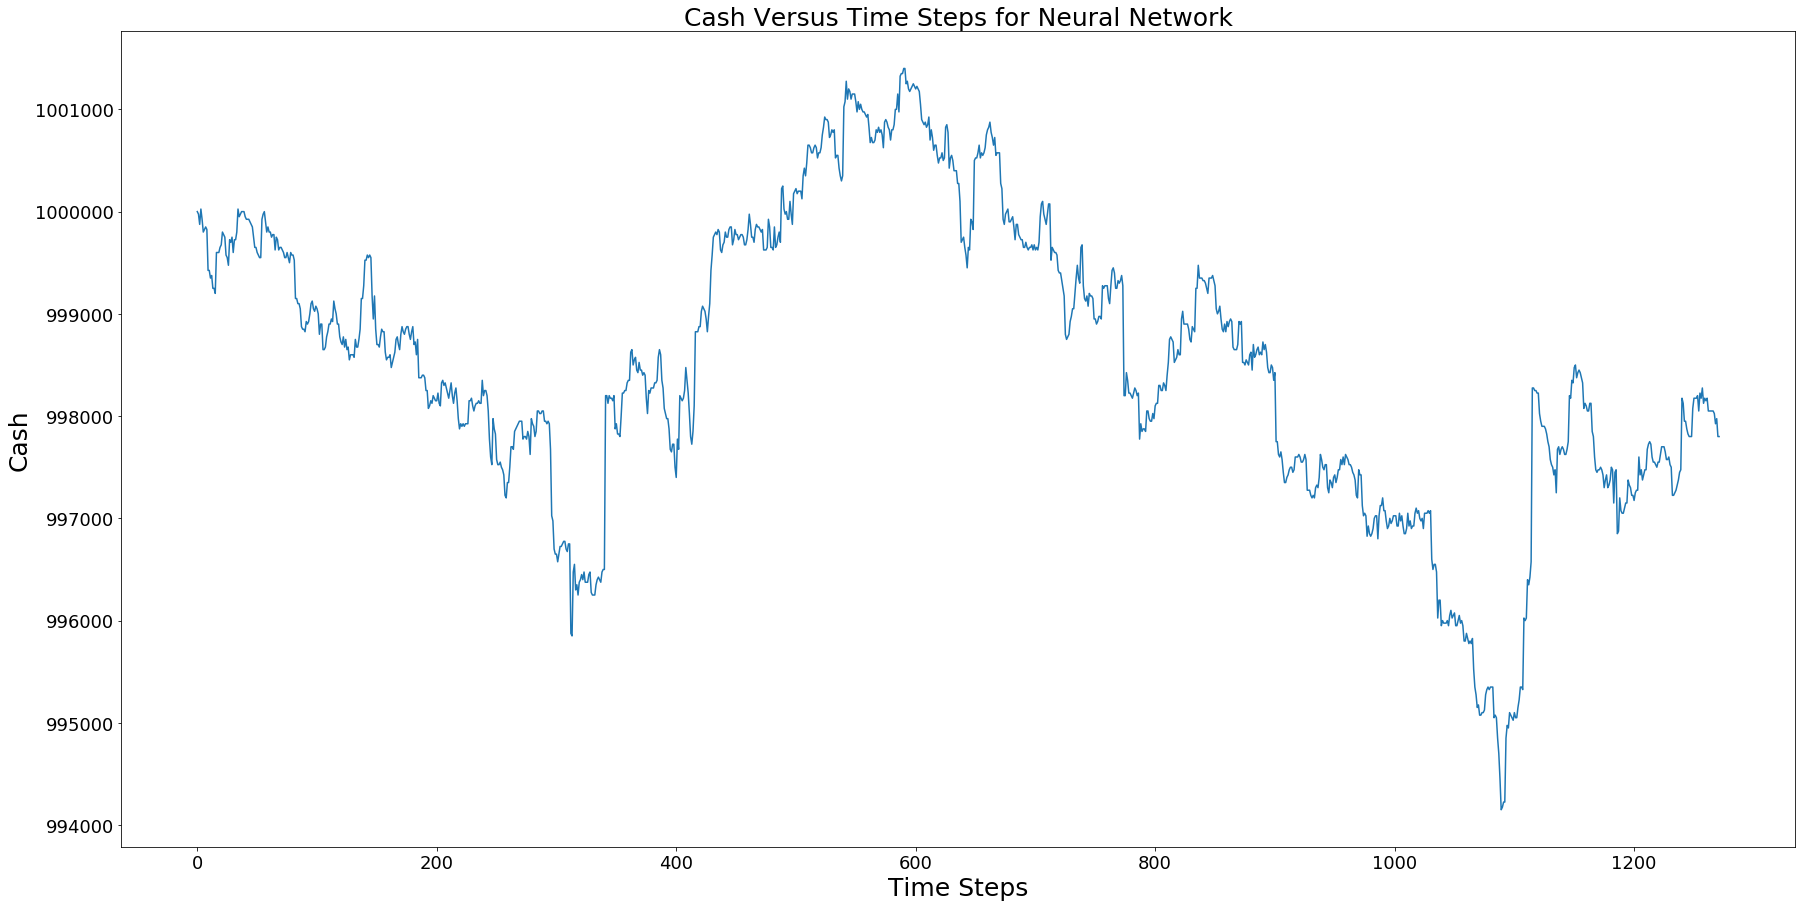

997800.0

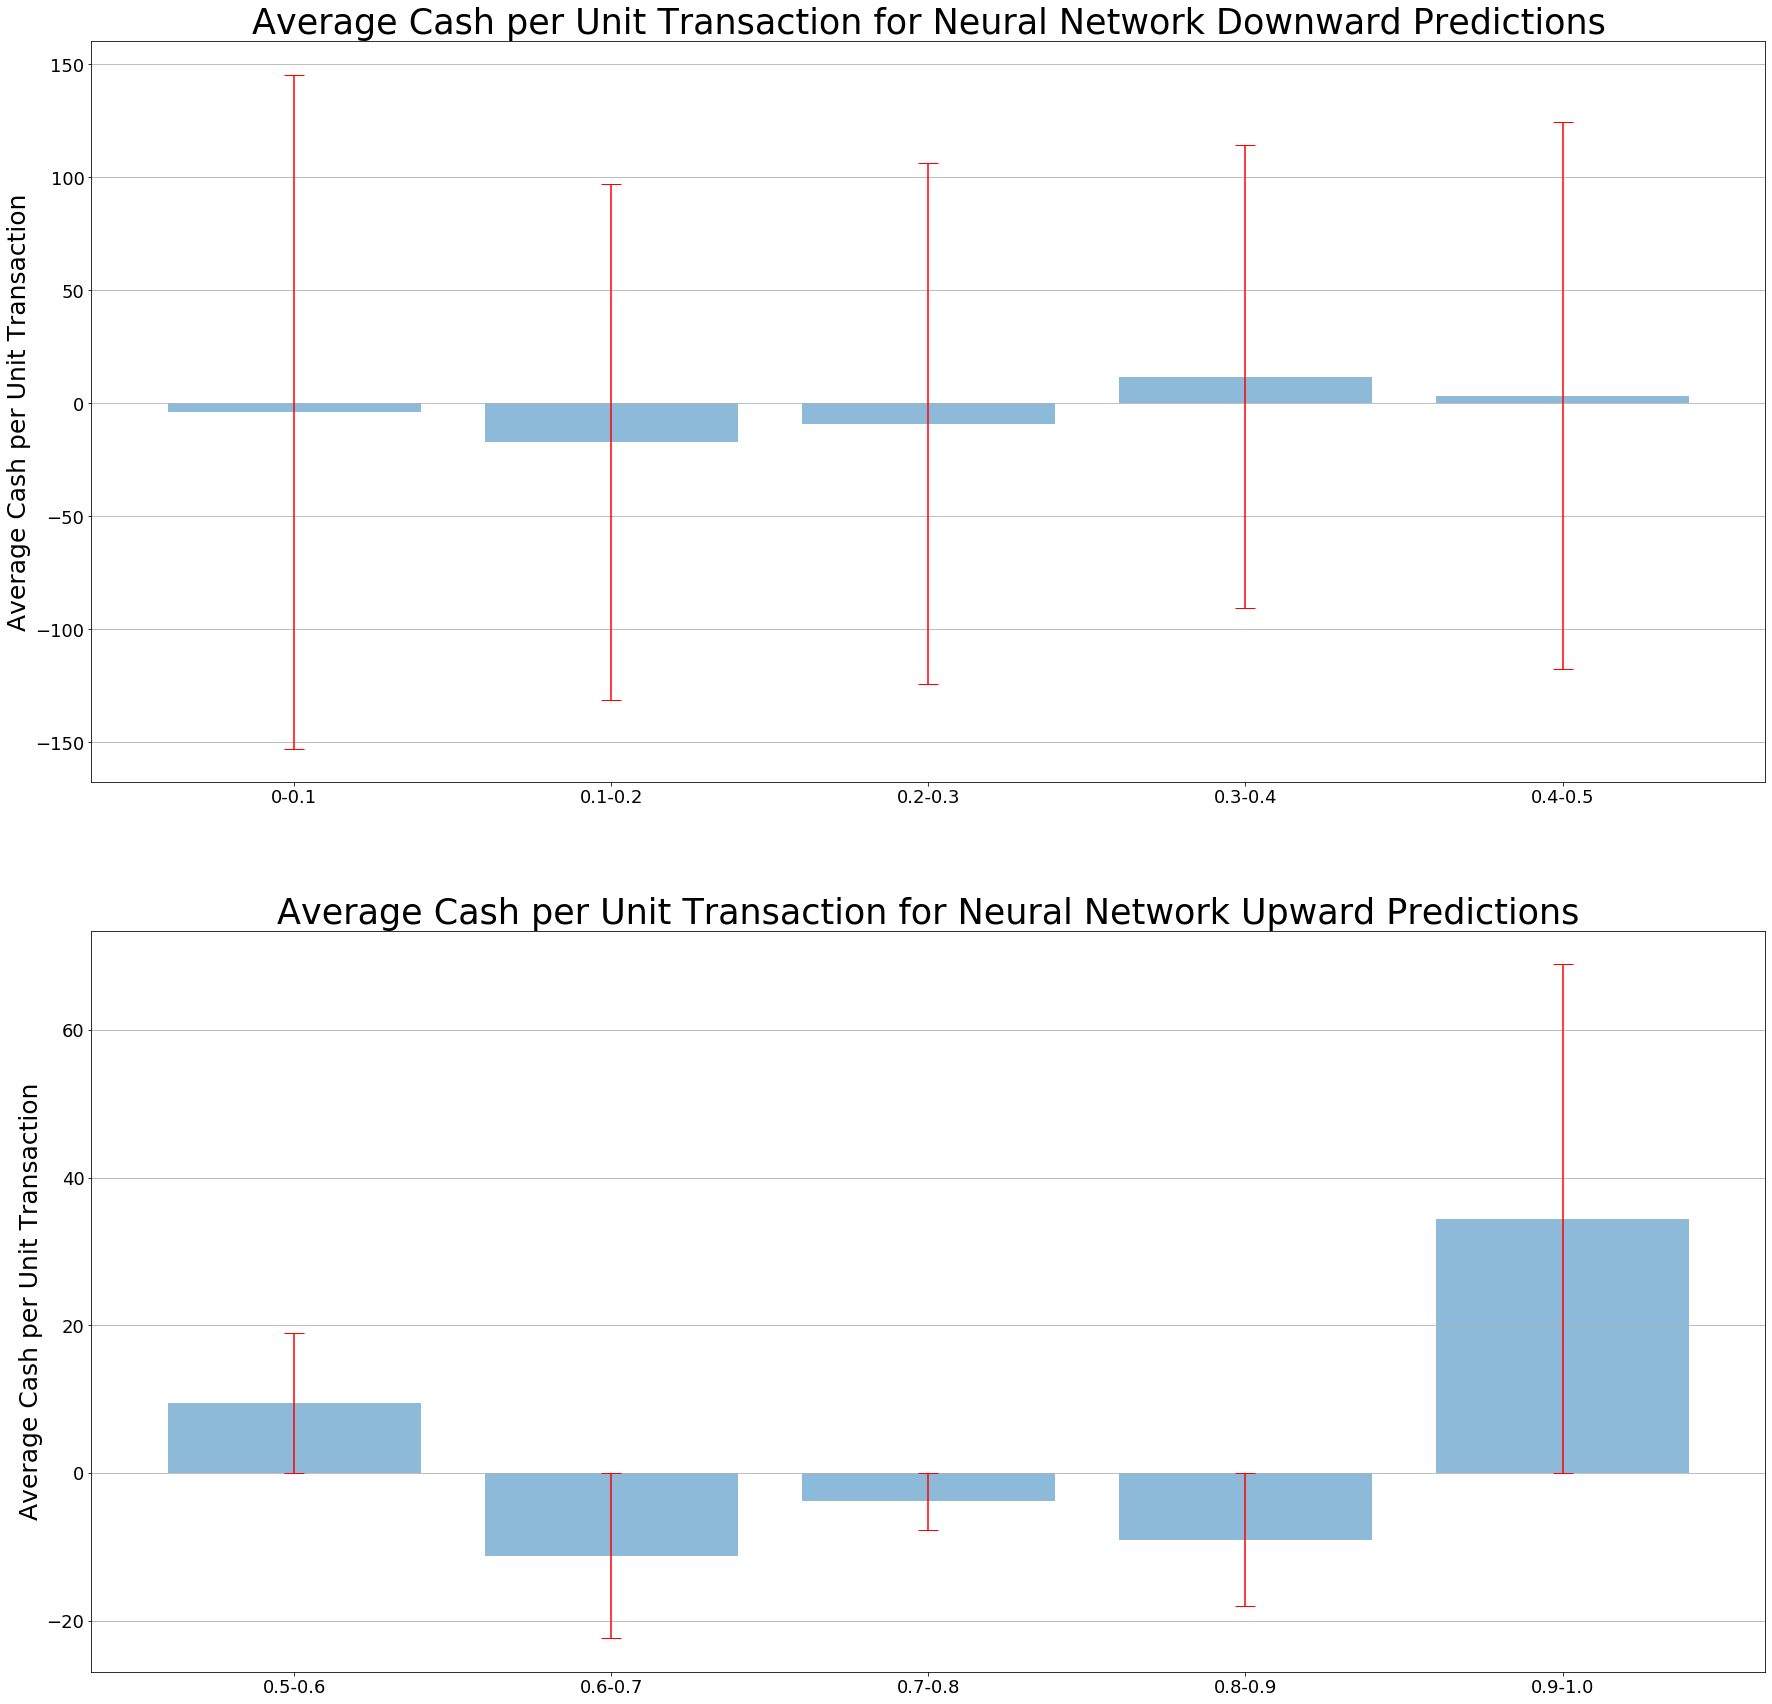

In [76]:
def evaluate(pred_df, stock_df, cash = 1000000, portfolio = 1000):
    pred_df['created_at'] = pd.to_datetime(pred_df['created_at'])
    cash_steps = []
    p00_01 = []
    p01_02 = []
    p02_03 = []
    p03_04 = []
    p04_05 = []
    p05_06 = []
    p06_07 = []
    p07_08 = []
    p08_09 = []
    p09_10 = []
    units = 100
    for i in range(len(pred_df)):
        p = pred_df['0'][i]
        current_time = pred_df['created_at'][i]
        #Gets index within stock dataframe of current time
        stock_time_idx = stock_df['Date_time'].loc[stock_df['Date_time'] == current_time].index[0]
        future_time = current_time + timedelta(minutes=5)  
        future_stock_time_idx = stock_df['Date_time'].loc[stock_df['Date_time'] == future_time].index[0]
        if pred_df['stock_up'][i] == 1:
            #Buy Close now and sell Open in five minutes
            cost_of_trans = units*(stock_df['Open'][future_stock_time_idx] - stock_df['Close'][stock_time_idx])
            if p >= 0.5 and p < 0.6:
                p05_06.append(cost_of_trans) 
            if p >= 0.6 and p < 0.7:
                p06_07.append(cost_of_trans) 
            if p >= 0.7 and p < 0.8:
                p07_08.append(cost_of_trans) 
            if p >= 0.8 and p < 0.9:
                p08_09.append(cost_of_trans) 
            if p >= 0.9 and p < 1:
                p09_10.append(cost_of_trans) 
        elif pred_df['stock_up'][i] == 0:
            #Sell Close now and Buy Open in five minutes 
            cost_of_trans = units*(stock_df['Close'][stock_time_idx] - stock_df['Open'][future_stock_time_idx]) 
            if p >= 0 and p < 0.1:
                p00_01.append(cost_of_trans)
            if p >= 0.1 and p < 0.2:
                p01_02.append(cost_of_trans)
            if p >= 0.2 and p < 0.3:
                p02_03.append(cost_of_trans) 
            if p >= 0.3 and p < 0.4:
                p03_04.append(cost_of_trans) 
            if p >= 0.4 and p < 0.5:
                p04_05.append(cost_of_trans) 
        cash = cash + cost_of_trans
        cash_steps.append(cash)
        
        
    timesteps = [j for j in range(len(pred_df))]
    plt.figure(figsize=(30,15))
    plt.plot(timesteps, cash_steps)
    plt.xlabel('Time Steps', fontsize = 25)
    plt.ylabel('Cash', fontsize = 25)
    plt.title('Cash Versus Time Steps for Neural Network', fontsize = 25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()
    
    down_mean = [np.mean(p00_01), np.mean(p01_02), np.mean(p02_03), np.mean(p03_04), np.mean(p04_05)]
    down_std = [np.std(p00_01), np.std(p01_02), np.std(p02_03), np.std(p03_04), np.std(p04_05)]
    down_p = ['0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5']
    down_pos = np.arange(len(down_p))
    
    up_mean = [np.mean(p05_06), np.mean(p06_07), np.mean(p07_08), np.mean(p08_09), np.mean(p09_10)]
    up_std = [np.mean(p05_06), np.mean(p06_07), np.mean(p07_08), np.mean(p08_09), np.mean(p09_10)]
    up_p = ['0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']
    up_pos = np.arange(len(up_p))
    
    fig, ax = plt.subplots(2, figsize=(30,30))
    ax[0].bar(down_pos, down_mean, yerr=down_std, align='center', alpha=0.5, ecolor='red', capsize=10)
    ax[0].set_ylabel('Average Cash per Unit Transaction', fontsize = 25)
    ax[0].set_xticks(down_pos)
    ax[0].set_xticklabels(down_p, fontsize = 25)
    ax[0].set_title('Average Cash per Unit Transaction for Neural Network Downward Predictions', fontsize = 35)
    ax[0].tick_params(axis='both', which='major', labelsize=18)
    ax[0].tick_params(axis='both', which='minor', labelsize=18)
    ax[0].yaxis.grid(True)
    
    ax[1].bar(up_pos, up_mean, yerr=up_std, align='center', alpha=0.5, ecolor='red', capsize=10)
    ax[1].set_ylabel('Average Cash per Unit Transaction', fontsize = 25)
    ax[1].set_xticks(up_pos)
    ax[1].set_xticklabels(up_p, fontsize = 25)
    ax[1].set_title('Average Cash per Unit Transaction for Neural Network Upward Predictions', fontsize = 35)
    ax[1].tick_params(axis='both', which='major', labelsize=18)
    ax[1].tick_params(axis='both', which='minor', labelsize=18)
    ax[1].yaxis.grid(True)
    
    return cash
evaluate(neural_pred, stock)


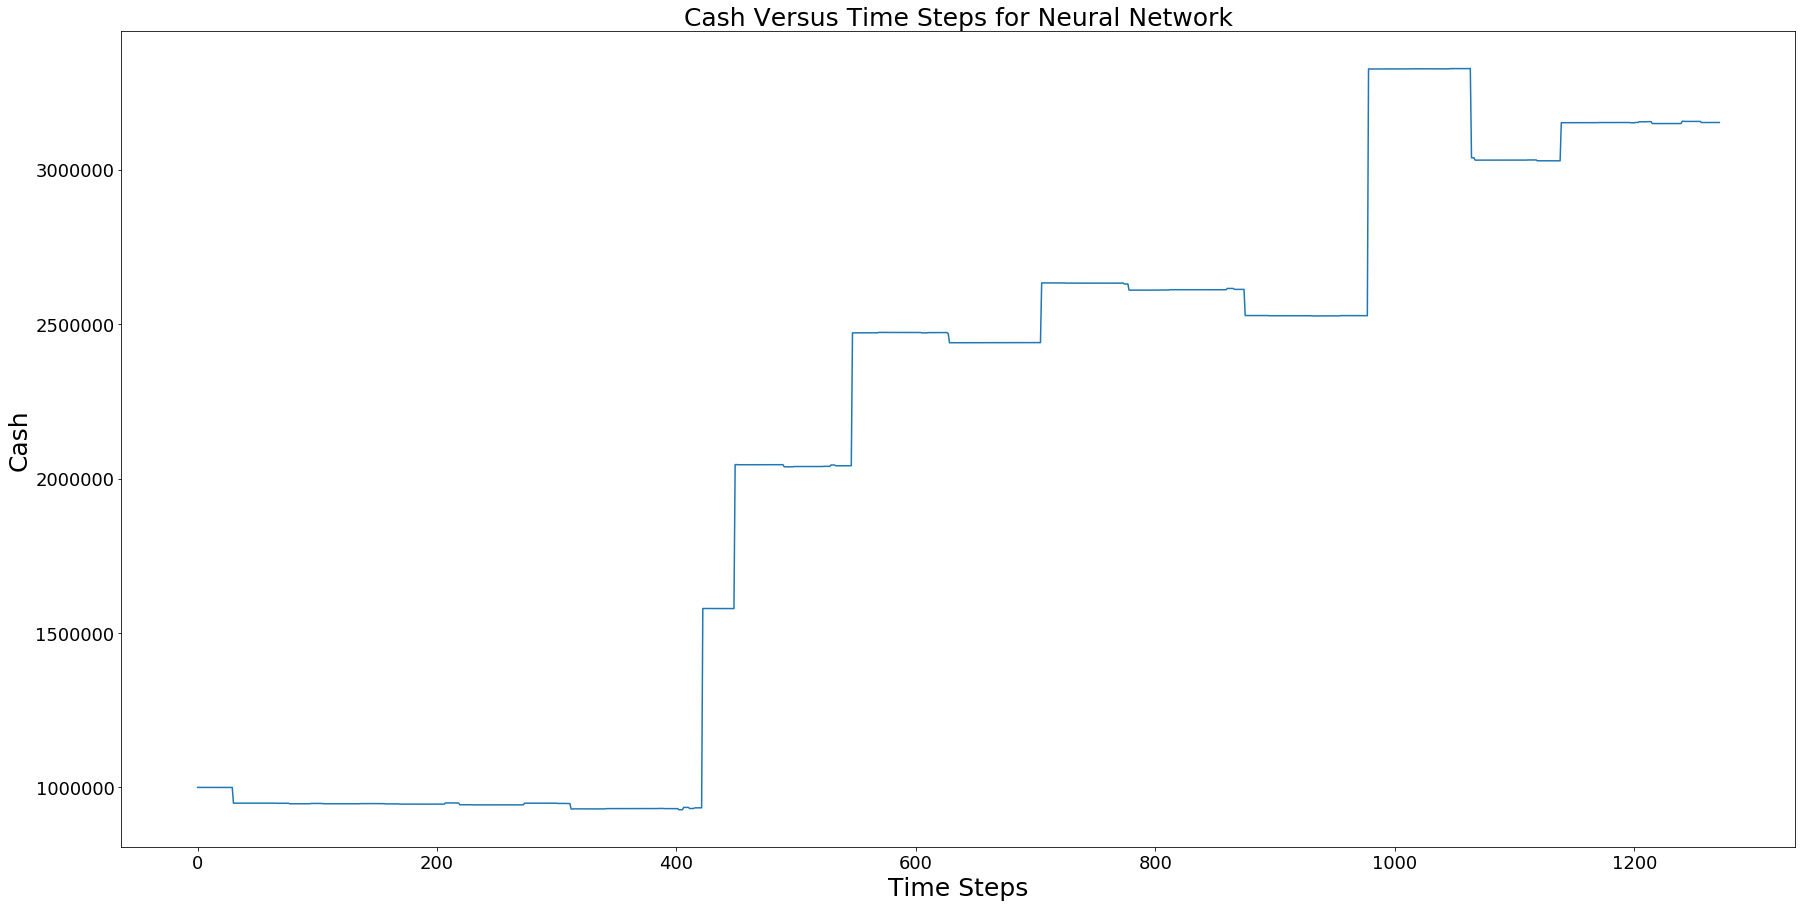

In [75]:
def prop_evaluate(pred_df, stock_df, cash = 1000000, portfolio = 1000):
    pred_df['created_at'] = pd.to_datetime(pred_df['created_at'])
    p00_01 = []
    p01_02 = []
    p02_03 = []
    p03_04 = []
    p04_05 = []
    p05_06 = []
    p06_07 = []
    p07_08 = []
    p08_09 = []
    p09_10 = []
    cash_steps = []
    for i in range(len(pred_df)):
        p = pred_df['0'][i]
        if p >= 0.5:
            units = 1/(1-p)
        if p < 0.5:
            units = 1/p
        current_time = pred_df['created_at'][i]
        #Gets index within stock dataframe of current time
        stock_time_idx = stock_df['Date_time'].loc[stock_df['Date_time'] == current_time].index[0]
        future_time = current_time + timedelta(minutes=5)  
        future_stock_time_idx = stock_df['Date_time'].loc[stock_df['Date_time'] == future_time].index[0]
        if pred_df['stock_up'][i] == 1:
            #Buy Close now and sell Open in five minutes
            cost_of_trans = units*stock_df['Open'][future_stock_time_idx] - units*stock_df['Close'][stock_time_idx] 
            cash = cash + cost_of_trans
            if p >= 0.5 and p < 0.6:
                p05_06.append(cost_of_trans) 
            if p >= 0.6 and p < 0.7:
                p06_07.append(cost_of_trans) 
            if p >= 0.7 and p < 0.8:
                p07_08.append(cost_of_trans) 
            if p >= 0.8 and p < 0.9:
                p08_09.append(cost_of_trans) 
            if p >= 0.9 and p < 1:
                p09_10.append(cost_of_trans) 
        elif pred_df['stock_up'][i] == 0:
            #Sell Close now and Buy Open in five minutes 
            cost_of_trans = units*stock_df['Close'][stock_time_idx] - units*stock_df['Open'][future_stock_time_idx] 
            cash = cash + cost_of_trans
            if p >= 0 and p < 0.1:
                p00_01.append(cost_of_trans)
            if p >= 0.1 and p < 0.2:
                p01_02.append(cost_of_trans)
            if p >= 0.2 and p < 0.3:
                p02_03.append(cost_of_trans) 
            if p >= 0.3 and p < 0.4:
                p03_04.append(cost_of_trans) 
            if p >= 0.4 and p < 0.5:
                p04_05.append(cost_of_trans) 
                
        cash_steps.append(cash)
    timesteps = [j for j in range(len(pred_df))]
    plt.figure(figsize=(30,15))
    plt.plot(timesteps, cash_steps)
    plt.xlabel('Time Steps', fontsize = 25)
    plt.ylabel('Cash', fontsize = 25)
    plt.title('Cash Versus Time Steps for Neural Network', fontsize = 25)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.show()
    plt.show()
    return cash
trans = prop_evaluate(neural_pred, stock)


In [62]:
min(trans)

-15897534.7441254